패션 MNIST 데이터를 CNN으로 분류하기

# 패션 MNIST 데이터 불러오기

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0 # 픽셀 스케일을 0~1로 정규화
# (48000, 28, 28) --> (48000, 28, 28, 1)
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


# CNN 만들기

먼저 첫 번째 Conv 층을 추가하자.

In [2]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28, 28, 1)))
# 32개 필터, 커널 (3, 3, 1), 활성화 함수 렐루, 새임 패딩, 입력 데이터 형태 (28, 28, 1)
# (28, 28, 1) --> (28, 28, 32)

다음으로 풀링 층을 추가하자.

In [3]:
model.add(keras.layers.MaxPooling2D(2))
# (28, 28, 32) --> (14, 14, 32)

두 번째 Conv 층과 풀링 층을 추가하자

In [4]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
# 64개 필터, 커널 (3, 3, 32), 활성화 함수 렐루, 새임 패딩
# (14, 14, 32) --> (14, 14, 64)
model.add(keras.layers.MaxPooling2D(2))
# (14, 14, 64) --> (7, 7, 64)

마지막으로 FC 층을 추가할 건데,

우선 Flatten으로 펼치고, 이전 예제와 같이 은닉층을 하나 더 두자.

은닉층과 출력층 사이에 드롭아웃을 걸자.

In [5]:
model.add(keras.layers.Flatten())
# (7, 7, 64) --> (3136, )
model.add(keras.layers.Dense(100, activation='relu'))
# (3136, ) --> (100, )
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))
# (100, ) --> (10, )

summary()로 모델 구조를 확인해보다

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

첫번째 conv에서는 3x3x1 커널이 32개 거기에 32개 가중치까지 해서 총 320개의 파라미터를 갖는다.

두번째 conv에서는 3x3x32 커널이 64개 거기에 64개 가중치까지 해서 총 18496개의 파라미터를 갖는다.

은닉층에서는 3136개의 입력과 1개 bias에 대한 가중치 세트가 100개 필요하므로 총 313700개의 파라미터를 갖는다.

출력층에서는 100개의 입력과 1개 bias에 대한 가중치 세트가 10개 필요하므로 총 1010개의 파라미터를 갖는다.

이번에는 층의 구성을 그림으로 표현해주는 plot_model() 함수를 이용해보자.
- show_shapes: 입력과 출력의 크기 표시 여부
- to_file: 출력한 이미지를 파일로 저장
- dpi: 해상도 지정

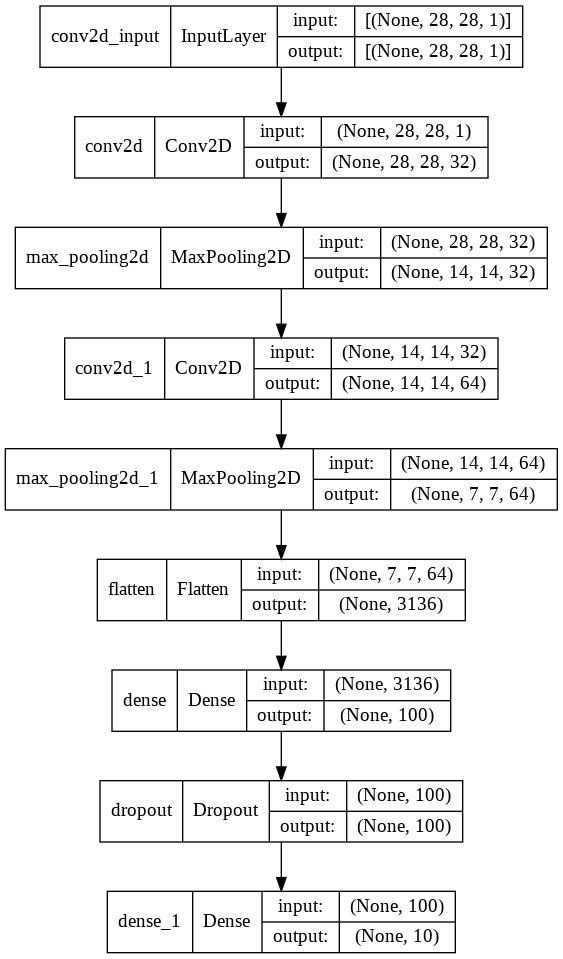

In [7]:
keras.utils.plot_model(model, show_shapes=True)

# 모델 컴파일과 훈련

케라스의 장점은 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 점이다.

여기서도 Adam 옵티마이저를 사용하고, ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용하여 조기 종료 기법을 구현해보자.

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 22s 7ms/step - loss: 0.5357 - accuracy: 0.8089 - val_loss: 0.3220 - val_accuracy: 0.8767
Epoch 2/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3549 - accuracy: 0.8735 - val_loss: 0.2751 - val_accuracy: 0.8953
Epoch 3/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3077 - accuracy: 0.8887 - val_loss: 0.2623 - val_accuracy: 0.8994
Epoch 4/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2714 - accuracy: 0.9013 - val_loss: 0.2403 - val_accuracy: 0.9099
Epoch 5/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2451 - accuracy: 0.9097 - val_loss: 0.2292 - val_accuracy: 0.9162
Epoch 6/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2256 - accuracy: 0.9163 - val_loss: 0.2237 - val_accuracy: 0.9170
Epoch 7/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2096 - accuracy: 0.9245 - val_loss: 0.2253 - val_ac

8번째 에포크에서 훈련이 중지되었다. --> 6번째 에포크가 최적의 모델일 것이다.

훈련 세트의 정확도가 많이 향상된 것 같다. 이제 손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인해보자.

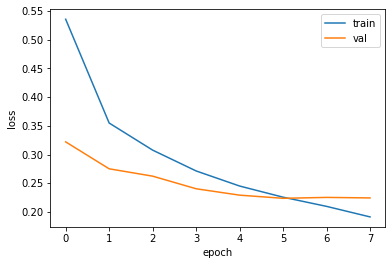

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

restore_best_weights=True 이므로, 현재 모델은 6번째 에포크의 상태일 것이다.

이번에는 검증 세트에 대한 평가를 해보자

In [10]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2237 - accuracy: 0.9170


[0.22369299829006195, 0.9169999957084656]

확실히 6번째 에포크의 훈련 결과와 동일한 결과이다.

이제 predict() 함수를 사용하여, 훈련된 모델에서 새로운 데이터에 대한 예측을 만들어보자.
- 편의상 검증 세트의 첫 번째 샘플을 새로운 데이터로 가정하자.

먼저 그 샘플 이미지를 확인해보자.

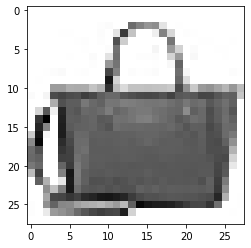

In [11]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [12]:
preds = model.predict(val_scaled[0:1]) # 슬라이싱
# 케라스의 fit(), predict(), evaluate() 함수는 모두 입력의 첫 차원이 배치 차원일 것으로 기대한다.
# 따라서 샘플 하나를 전달할 때 (28, 28, 1)이 아닌 (1, 28, 28, 1)을 전달해야 한다.
print(preds)

[[5.6457504e-16 4.1157335e-24 5.6380714e-22 5.2637322e-20 1.3124490e-18
  1.6632170e-17 1.6551409e-17 4.3991463e-16 1.0000000e+00 4.2221051e-16]]


9번째 값이 1이고, 다른 값은 0에 가깝다.

그래프로는 어떻게 표현될까?

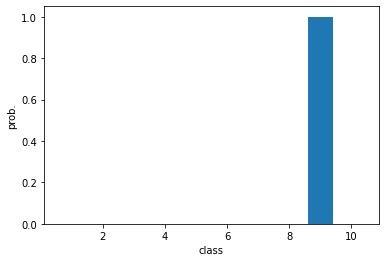

In [13]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

7장에서 패션 MNIST 데이터셋의 라벨을 보았었다.

[0: 티셔츠, 1: 바지, 2: 스웨터, 3: 드레스, 4: 코드,
 5: 샌달, 6: 셔츠, 7: 스니커즈, 8: 가방, 9: 앵클 부츠]

즉 9번째 라벨인 가방으로 잘 예측된 것을 확인할 수 있었다.


마지막으로 맨 처음에 떼어 놓았던 테스트 세트로 CNN의 일반화 성능을 가늠해보자.
- 훈련 데이터처럼 테스트 데이터도 전처리가 필요하다.

In [14]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 5ms/step - loss: 0.2362 - accuracy: 0.9136


[0.23619845509529114, 0.9136000275611877]

오예!

다음 절에서는 Conv 층의 가중치와 특성 맵을 시각화하여 신경망이 학습한 내용에 대해 고찰해보자.